<h1> <center> GEOG 172: INTERMEDIATE GEOGRAPHICAL ANALYSIS </h1>
    <h2> <center> Evgeny Noi </h2>
        <h3> <center> Lecture 16: Regression Diagnostics and GWR </h3>

# Plan for today 

1. Regression Diagnostics 
2. Spatial Regression (GWR)

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 
import seaborn as sns
import pingouin as pg
import statsmodels
import statsmodels.formula.api as smf
from pysal.model import spreg
from libpysal.weights import Queen, Rook, KNN
from esda.moran import Moran
from pysal.explore import esda

C:\Users\barguzin\anaconda3\envs\geo_env\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
db = gpd.read_file("regression_db.geojson")
print(db.shape) 
db.head()

(6110, 20)


,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.21870 32.74202)


In [3]:
variable_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

Text(0.5, 1.0, 'log(Price)')

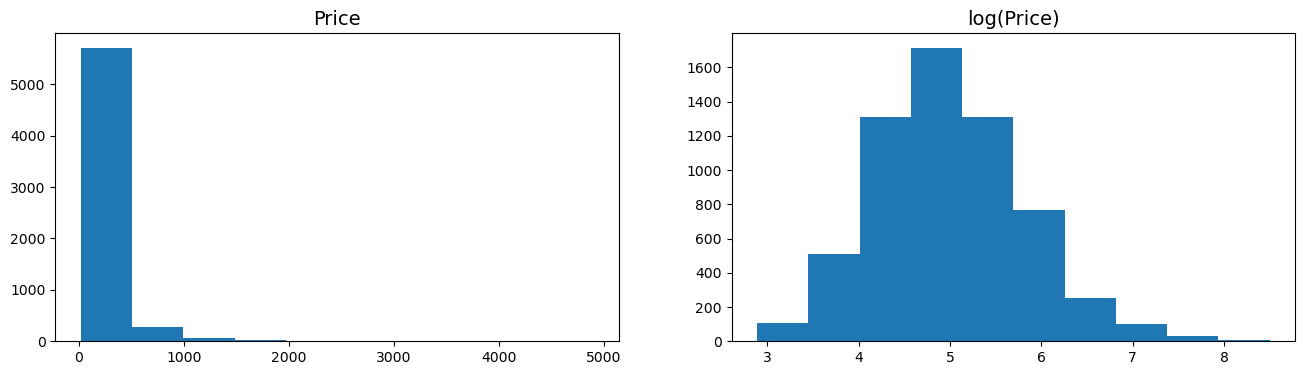

In [4]:
fig, ax = plt.subplots(1,2, figsize=(16,4))

ax[0].hist(db.price);
ax[0].set_title('Price', fontsize=14)
ax[1].hist(db.log_price);
ax[1].set_title('log(Price)', fontsize=14)

In [5]:
# Fitting linear model
res = smf.ols(formula= "log_price ~ accommodates + bathrooms + bedrooms + beds + rt_Private_room + rt_Shared_room + \
              pg_Condominium + pg_House + pg_Other + pg_Townhouse", data=db).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     1229.
Date:                Sun, 20 Nov 2022   Prob (F-statistic):               0.00
Time:                        22:56:21   Log-Likelihood:                -3988.9
No. Observations:                6110   AIC:                             8000.
Df Residuals:                    6099   BIC:                             8074.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.3884      0.016    272.322      0.000       4.357       4.420
accommodates        0.0835      0.005     16.434      0.000       0.073       0.093
bathrooms           0.1924      0.011     17.542      0.000       0.171       0.214
bedrooms            0.1525      0.011     13.701      0.000       0.131       0.174
beds               -0.0417      0.007     -6.013      0.000      -0.055      -0.028
rt_Private_room    -0.5507      0.016    -34.624      0.000      -0.582      -0.520
rt_Shared_room     -1.2383      0.038    -32.220      0.000      -1.314      -1.163
pg_Condominium      0.1436      0.022      6.485      0.000       0.100       0.187
pg_House           -0.0105      0.015     -0.722      0.470      -0.039       0.018
pg_Other            0.1412      0.023      6.191      0.000       0.096       0.186
pg_Townhouse       -0.0417      0.034     -1.216      0.224      -0.109       0.026
==============================================================================
Omnibus:                      964.842   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2671.611
Skew:                           0.850   Prob(JB):                         0.00
Kurtosis:                       5.758   Cond. No.                         41.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# base code
import numpy as np
import seaborn as sns
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type
import statsmodels.stats.api as sms

style_talk = 'seaborn-talk'    #refer to plt.style.available

class Linear_Reg_Diagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Author:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)

    def __call__(self, plot_context='seaborn-paper'):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(ax=ax[1,1])
            plt.show()

        self.vif_table()
        return fig, ax


    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.sort(residual_abs))
        abs_resid_top_3 = abs_resid[:3]
        for i, _ in enumerate(abs_resid_top_3):
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(np.flip(QQ.theoretical_quantiles, 0)[r], self.residual_norm[i]),
                ha='right', color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')
        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        xtemp, ytemp = self.__cooks_dist_line(0.5) # 0.5 line
        ax.plot(xtemp, ytemp, label="Cook's distance", lw=1, ls='--', color='red')
        xtemp, ytemp = self.__cooks_dist_line(1) # 1 line
        ax.plot(xtemp, ytemp, lw=1, ls='--', color='red')

        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        ax.legend(loc='upper right')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        print(vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

<AxesSubplot:title={'center':'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

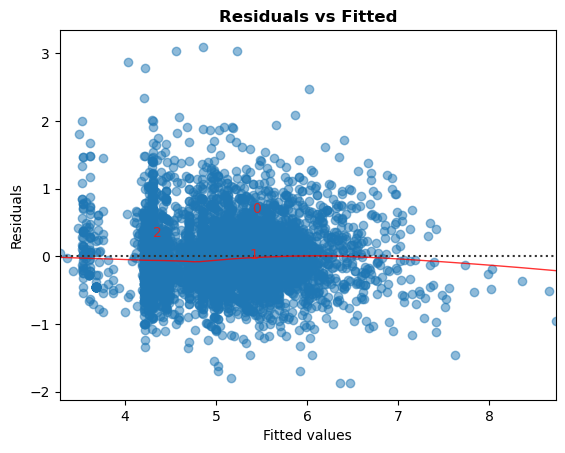

In [7]:
cls = Linear_Reg_Diagnostic(res)

cls.residual_plot()

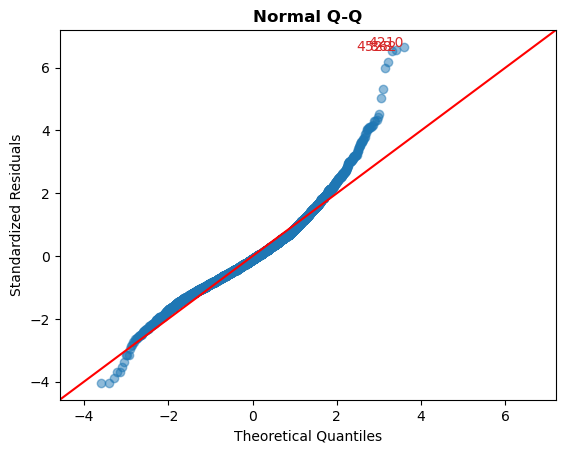

In [8]:
cls.qq_plot();

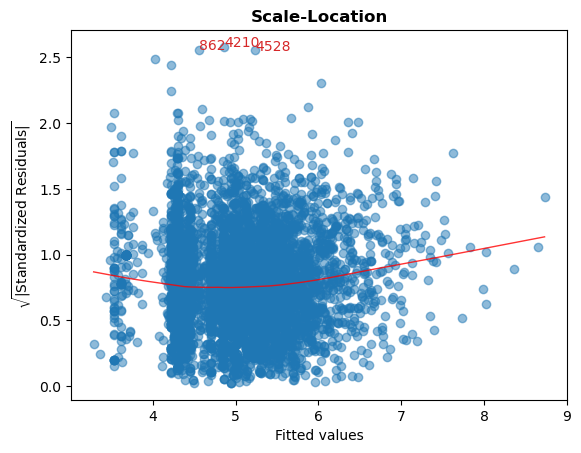

In [9]:
cls.scale_location_plot();

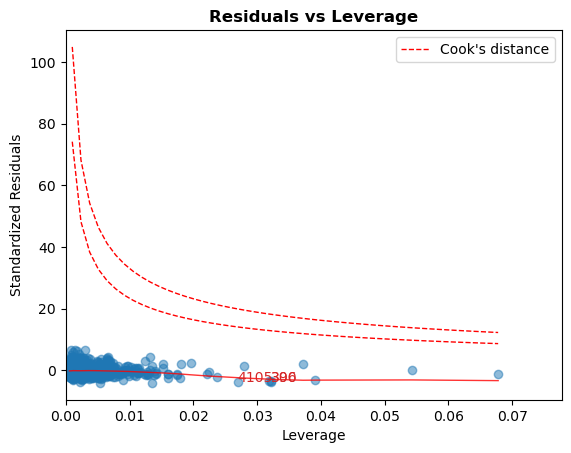

In [10]:
# look out for the points outside of the Cook's curves
cls.leverage_plot();

In [11]:
# look out for the variance inflation factor (VIF) > 5 
cls.vif_table()

           Features  VIF Factor
10     pg_Townhouse        1.09
6    rt_Shared_room        1.13
7    pg_Condominium        1.15
9          pg_Other        1.17
8          pg_House        1.45
5   rt_Private_room        1.49
2         bathrooms        2.53
4              beds        3.99
3          bedrooms        4.52
1      accommodates        5.87
0         Intercept        7.33


# Getting at Spatial Structure of Data 

1. Visual plots 
2. Global Moran's I 
3. Local Moran's I 

In [12]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Dependent variable name
    name_y="log_price",
    # Independent variable name
    name_x=variable_names,
)

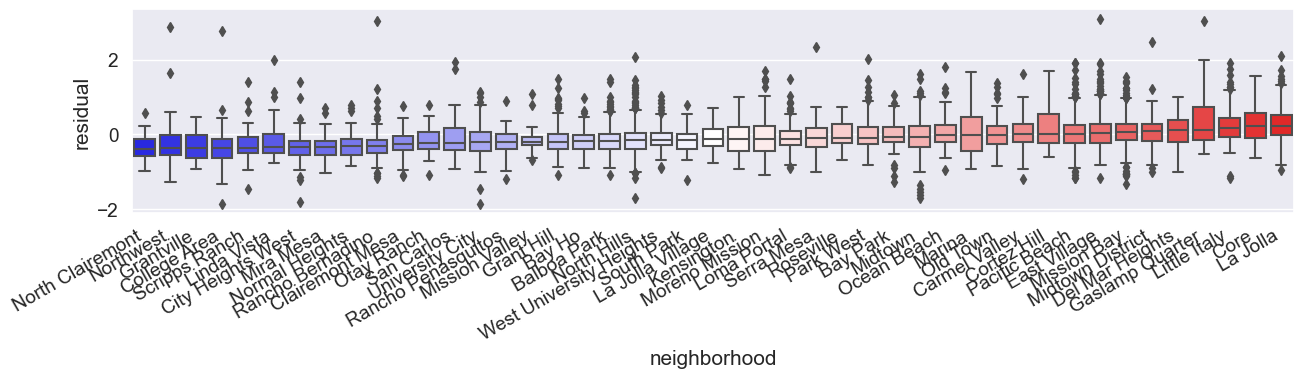

In [13]:
# Create column with residual values from m1
db["residual"] = m1.u
# Obtain the median value of residuals in each neighbourhood
medians = (db.groupby("neighborhood").residual.median().to_frame("hood_residual"))

# Increase fontsize
sns.set(font_scale=1.25)
# Set up figure
f = plt.figure(figsize=(15, 3))
# Grab figure's axis
ax = plt.gca()
# Generate bloxplot of values by neighbourhood
data=db.merge(medians, how="left", left_on="neighborhood", right_index=True).sort_values("hood_residual")
# Note the data includes the median values merged on-the-fly
sns.boxplot(
    x="neighborhood",
    y="residual",
    ax=ax,
    data=data,
    palette="bwr"
)
# Auto-format of the X labels
f.autofmt_xdate()
# Display
plt.show()

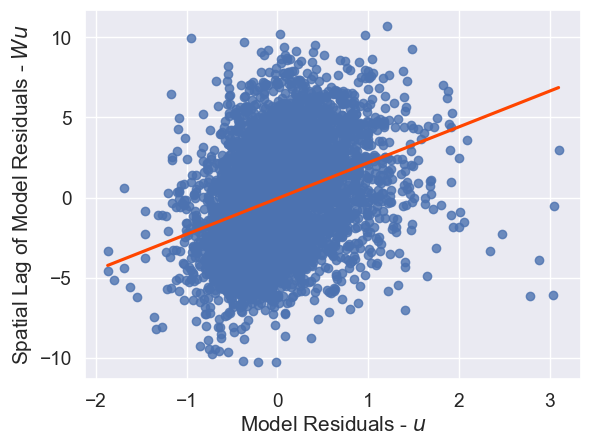

In [14]:
from pysal.lib import weights
w_knn = KNN.from_dataframe(db, k=15)

lag_residual = weights.spatial_lag.lag_spatial(w_knn, m1.u)
ax = sns.regplot(
    x=m1.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Model Residuals - $u$")
ax.set_ylabel("Spatial Lag of Model Residuals - $W u$");

In [15]:
moran = Moran(res.resid, w_knn)
print(moran.I, moran.p_sim)

0.14904244159430066 0.001


# Interpreting Moran Scatterplot

> When the model tends to over-predict a given AirBnB’s nightly log price, sites around that AirBnB are more likely to also be over-predicted.

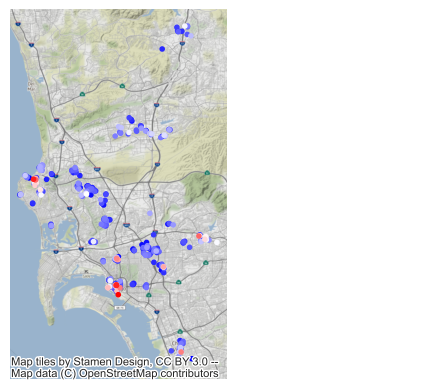

In [16]:
import contextily
# Re-weight W to 20 nearest neighbors
# knn.reweight(k=20, inplace=True)
# Row standardise weights
w_knn.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, w_knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = outliers.q % 2 == 1
# Filter out non-significant clusters
error_clusters &= outliers.p_sim <= 0.001
# Add `error_clusters` and `local_I` columns
ax = (
    db.assign(
        error_clusters=error_clusters,
        local_I=outliers.Is
        # Retain error clusters only
    )
    .query(
        "error_clusters"
        # Sort by I value to largest plot on top
    )
    .sort_values(
        "local_I"
        # Plot I values
    )
    .plot("local_I", cmap="bwr", marker=".")
)
# Add basemap
contextily.add_basemap(ax, crs=db.crs)
# Remove axes
ax.set_axis_off();

# Interpreting LISA maps 

> Coldspots - underpredictions, hotspots - overpredictions. We observe spatial patterns to model residuals (predictive performance). 

#### We need to bring geography into regression framework 

# Spatial Regression 

* Explicitly introduces space or geographical context into the statistical framework of a regression
* Space can act as a reasonable proxy for other factors we cannot but should include in our model.
* **Construct spatial featrues to bring geography!**
    * proximity to Balboa Park (tourist attraction) 

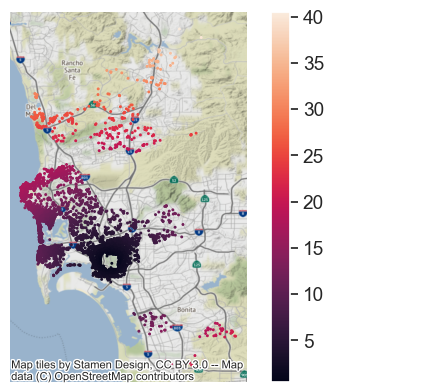

In [17]:
ax = db.plot("d2balboa", marker=".", s=5, legend=True)
contextily.add_basemap(ax, crs=db.crs)
ax.set_axis_off();

In [18]:
balboa_names = variable_names + ["d2balboa"]
m2 = spreg.OLS(db[["log_price"]].values,db[balboa_names].values,name_y="log_price",name_x=balboa_names,)
pd.DataFrame(
    [[m1.r2, m1.ar2], [m2.r2, m2.ar2]],
    index=["M1", "M2"],
    columns=["R2", "Adj. R2"],
) # the model fit does not change 

,R2,Adj. R2
M1,0.668345,0.667801
M2,0.668502,0.667904


In [19]:
# Set up table of regression coefficients
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m2.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m2.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m2.t_stat],
    },
    index=m2.name_x,
)

,Coeff.,Std. Error,P-Value
CONSTANT,4.379624,0.016915,0.000000e+00
accommodates,0.083644,0.005079,1.156896e-59
bathrooms,0.190791,0.011005,9.120139e-66
bedrooms,0.150746,0.011179,7.418035e-41
beds,-0.041476,0.006939,2.394322e-09
rt_Private_room,-0.552996,0.015960,2.680270e-240
rt_Shared_room,-1.235521,0.038462,2.586867e-209
pg_Condominium,0.140459,0.022225,2.803765e-10
pg_House,-0.013302,0.014623,3.630396e-01
pg_Other,0.141176,0.022798,6.309880e-10


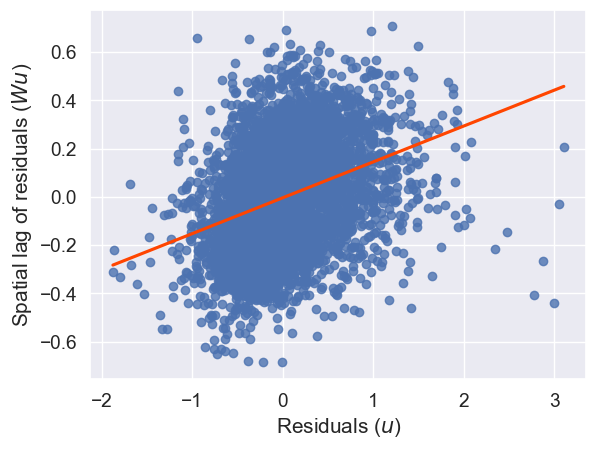

In [20]:
lag_residual = weights.spatial_lag.lag_spatial(w_knn, m2.u)
ax = sns.regplot(
    x=m2.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Residuals ($u$)")
ax.set_ylabel("Spatial lag of residuals ($Wu$)");

# Observations About Model 2 

* We still observe clustering in residuals (something we are not capturing well) - GEO 
* Positive coefficient for Balboa is not intuitive (we are paying more to stay farther from Balboa)

# Spatial Heterogeneity 

* We have assumed that the influence of distance is uniform across the study area, BUT some neighborhoods are systematically more expensive than others. 
* **parts of the model vary systematically with geography** 

# Spatial Fixed Effects 

* Captures the fixed effect through a proxy that influences price (neighborhood) 
* Create a separate binary variable for each of the $r$ neighborhoods

$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

where $\alpha_r$ varies across neighborhoods

In [21]:
f = (
    "log_price ~ "
    + " + ".join(variable_names)
    + " + neighborhood - 1"
)
print(f)

log_price ~ accommodates + bathrooms + bedrooms + beds + rt_Private_room + rt_Shared_room + pg_Condominium + pg_House + pg_Other + pg_Townhouse + neighborhood - 1


In [22]:
m3 = smf.ols(f, data=db).fit()

In [23]:
# Store variable names for all the spatial fixed effects
sfe_names = [i for i in m3.params.index if "neighborhood[" in i]
# Create table
pd.DataFrame(
    {
        "Coef.": m3.params[sfe_names],
        "Std. Error": m3.bse[sfe_names],
        "P-Value": m3.pvalues[sfe_names],
    }
).head(10)

,Coef.,Std. Error,P-Value
neighborhood[Balboa Park],4.280766,0.033292,0.0
neighborhood[Bay Ho],4.198251,0.076878,0.0
neighborhood[Bay Park],4.329223,0.050987,0.0
neighborhood[Carmel Valley],4.389261,0.056553,0.0
neighborhood[City Heights West],4.053518,0.058378,0.0
neighborhood[Clairemont Mesa],4.095259,0.047699,0.0
neighborhood[College Area],4.033697,0.058258,0.0
neighborhood[Core],4.726186,0.052643,0.0
neighborhood[Cortez Hill],4.608090,0.051526,0.0
neighborhood[Del Mar Heights],4.496910,0.054337,0.0


In [24]:
# spreg spatial fixed effect implementation
m4 = spreg.OLS_Regimes(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Variable specifying neighborhood membership
    db["neighborhood"].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    # Variables to be allowed to vary (True) or kept
    # constant (False). Here we set all to False
    cols2regi=[False] * len(variable_names),
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

In [25]:
np.round(m4.betas.flatten() - m3.params.values, decimals=12)

array([-0.e+00,  4.e-12,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00, -2.e-12,  0.e+00, -0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
       -0.e+00,  0.e+00,  0.e+00, -0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00, -0.e+00, -0.e+00,  0.e+00,
       -0.e+00, -0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00])

In [26]:
neighborhood_effects = m3.params.filter(like="neighborhood")

# Create a sequence with the variable names without
# `neighborhood[` and `]`
stripped = neighborhood_effects.index.str.strip(
    "neighborhood["
).str.strip("]")
# Reindex the neighborhood_effects Series on clean names
neighborhood_effects.index = stripped
# Convert Series to DataFrame
neighborhood_effects = neighborhood_effects.to_frame("fixed_effect")
# Print top of table
neighborhood_effects.head()

,fixed_effect
Balboa Park,4.280766
Bay Ho,4.198251
Bay Park,4.329223
Carmel Valley,4.389261
City Heights West,4.053518


In [27]:
import urllib.request
urllib.request.urlretrieve("http://data.insideairbnb.com/united-states/ca/san-diego/2022-09-18/visualisations/neighbourhoods.geojson ", "sd_geo.geojson")

('sd_geo.geojson', <http.client.HTTPMessage at 0x20bf9f0a230>)

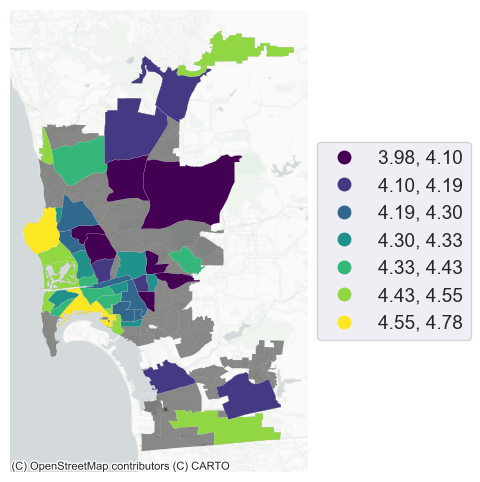

In [28]:
neighborhoods = gpd.read_file('sd_geo.geojson')

# Plot base layer with all neighborhoods in grey
ax = neighborhoods.plot(
    color="k", linewidth=0, alpha=0.5, figsize=(12, 6), legend=True
)
# Merge SFE estimates (note not every polygon
# receives an estimate since not every polygon
# contains AirBnb properties)
neighborhoods.merge(
    neighborhood_effects,
    how="left",
    left_on="neighbourhood",
    right_index=True
    # Drop polygons without a SFE estimate
).dropna(
    subset=["fixed_effect"]
    # Plot quantile choropleth
).plot(
    "fixed_effect",  # Variable to display
    scheme="quantiles",  # Choropleth scheme
    k=7,  # No. of classes in the choropleth
    linewidth=0.1,  # Polygon border width
    cmap="viridis",  # Color scheme
    ax=ax,  # Axis to draw on
    legend=True, 
    legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)}
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=neighborhoods.crs,
    source=contextily.providers.CartoDB.PositronNoLabels,
)
# Remove axis
ax.set_axis_off()
# Display
plt.show()

# Interpeting Spatial Fixed Effects 

> We can see a clear spatial structure in the SFE estimates. The most expensive neighborhoods tend to be located nearby the coast, while the cheapest ones are more inland.

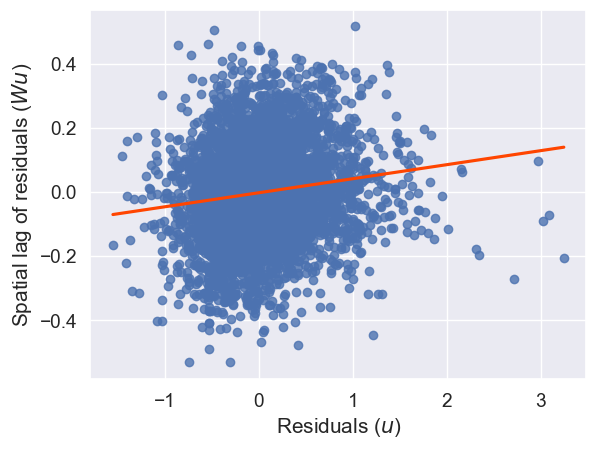

In [29]:
lag_residual = weights.spatial_lag.lag_spatial(w_knn, m4.u)
ax = sns.regplot(
    x=m4.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Residuals ($u$)")
ax.set_ylabel("Spatial lag of residuals ($Wu$)");

In [30]:
moran = Moran(m4.u, w_knn)
print(moran.I, moran.p_sim) # smaller Moran's I (compared to .14) 

0.04374941138999537 0.001


# Spatial Regimes 

> Allow not only intercepts, but beta coefficients to vary 

$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ki}\beta_{k-r} + \epsilon_i
$$

In [31]:
# Pysal spatial regimes implementation
m5 = spreg.OLS_Regimes(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Variable specifying neighborhood membership
    db["coastal"].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

In [32]:
# Results table
res = pd.DataFrame({
        "Coeff.": m5.betas.flatten(),
        "Std. Error": m5.std_err.flatten(),
        "P-Value": [i[1] for i in m5.t_stat],},
    index=m5.name_x,
)

coastal = [i for i in res.index if "1_" in i]
coastal = res.loc[coastal, :].rename(lambda i: i.replace("1_", ""))

coastal.columns = pd.MultiIndex.from_product([["Coastal"], coastal.columns])

ncoastal = [i for i in res.index if "0_" in i]

ncoastal = res.loc[ncoastal, :].rename(lambda i: i.replace("0_", ""))

ncoastal.columns = pd.MultiIndex.from_product([["Non-coastal"], ncoastal.columns])

# Concat both models
pd.concat([coastal, ncoastal], axis=1)

Coastal                          Non-coastal             \
                   Coeff. Std. Error       P-Value      Coeff. Std. Error   
CONSTANT         4.479904   0.025094  0.000000e+00    4.407242   0.021516   
accommodates     0.048464   0.007881  8.253761e-10    0.090186   0.006474   
bathrooms        0.247478   0.016566  1.381278e-49    0.143376   0.014268   
bedrooms         0.189740   0.017923  5.783965e-26    0.112963   0.013827   
beds            -0.050608   0.010743  2.522348e-06   -0.026272   0.008838   
rt_Private_room -0.558628   0.028312  4.723759e-84   -0.529334   0.018918   
rt_Shared_room  -1.052854   0.084174  1.836512e-35   -1.224459   0.042597   
pg_Condominium   0.204447   0.033943  1.810152e-09    0.105307   0.028131   
pg_House         0.075353   0.023378  1.274269e-03   -0.045447   0.017957   
pg_Other         0.295485   0.038645  2.394157e-14    0.060753   0.027637   
pg_Townhouse    -0.073508   0.049367  1.365396e-01   -0.010397   0.045673   

                                
                       P-Value  
CONSTANT          0.000000e+00  
accommodates      1.893020e-43  
bathrooms         1.418804e-23  
bedrooms          3.731742e-16  
beds              2.964354e-03  
rt_Private_room  3.546091e-162  
rt_Shared_room   1.657163e-170  
pg_Condominium    1.831822e-04  
pg_House          1.140318e-02  
pg_Other          2.796727e-02  
pg_Townhouse      8.199294e-01

In [33]:
m5.chow.joint

(328.86902143031756, 7.113548767239792e-64)

In [34]:
pd.DataFrame(
    # Chow results by variable
    m5.chow.regi,
    # Name of variables
    index=m5.name_x_r,
    # Column names
    columns=["Statistic", "P-value"],
)

,Statistic,P-value
CONSTANT,4.832180,2.793329e-02
accommodates,16.735685,4.296522e-05
bathrooms,22.671471,1.922004e-06
bedrooms,11.503786,6.945459e-04
beds,3.060313,8.022620e-02
rt_Private_room,0.740097,3.896298e-01
rt_Shared_room,3.308838,6.890820e-02
pg_Condominium,5.057283,2.452265e-02
pg_House,16.792503,4.169771e-05
pg_Other,24.409876,7.786847e-07


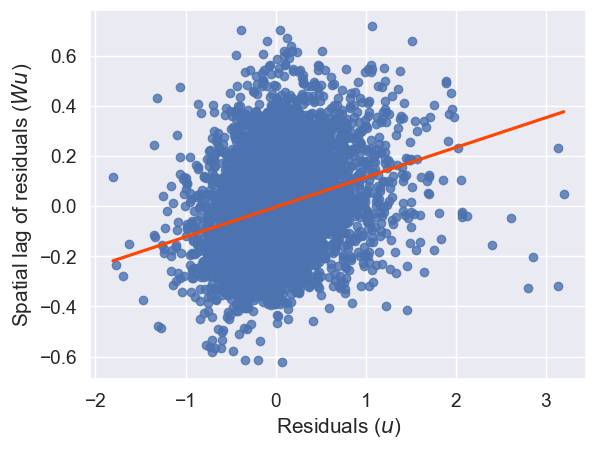

In [35]:
lag_residual = weights.spatial_lag.lag_spatial(w_knn, m5.u)
ax = sns.regplot(
    x=m5.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Residuals ($u$)")
ax.set_ylabel("Spatial lag of residuals ($Wu$)");

In [36]:
moran = Moran(m5.u, w_knn)
print(moran.I, moran.p_sim) # smaller Moran's I (compared to m2 - .14, but larger than m4 - .4) 

0.11880651767401344 0.001


# Spatial Dependence 

* We shift our interest from explicitly linked geography, to **spatial configuration**. Think about neighborhood as generalization of surroundings. The look and feel of the neighborhood might depend on how some of them vary in terms of nearby configurations (townhouse next to other townhouses). 
* **Spatial dependence** through distance
    * SLX model 
    * Spatial Error
    * Spatial Lag 

# SLX Model (Exogenous effects) 

$$
\log(P_i) = \alpha + \sum^{p}_{k=1}X_{ij}\beta_j + \sum^{p}_{k=1}\left(\sum^{N}_{j=1}w_{ij}x_{jk}\right)\gamma_k + \epsilon_i
$$

$$
\log(P_i) = \alpha + \mathbf{X}\beta + \mathbf{WX}\gamma + \epsilon
$$

* We separate spatial effects into direct ($\beta$) and indirect ($\gamma$). 

# SLX Model (Example) 

* Add spatial lag of type of houses in the neighborhood (surrounding) 
* Association between the price in a given house and a unit change in its average surroundings 
* Spillover effect

In [37]:
# Select only columns in `db` containing the keyword `pg_`
wx = (
    db.filter(
        like="pg_"
        # Compute the spatial lag of each of those variables
    )
    .apply(
        lambda y: weights.spatial_lag.lag_spatial(w_knn, y)
        # Rename the spatial lag, adding w_ to the original name
    )
    .rename(
        columns=lambda c: "w_"
        + c
        # Remove the lag of the binary variable for apartments
    )
    .drop("w_pg_Apartment", axis=1)
)

In [38]:
# Merge original variables with the spatial lags in `wx`
slx_exog = db[variable_names].join(wx)
# Fit linear model with `spreg`
m6 = spreg.OLS(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    slx_exog.values,
    # Dependent variable name
    name_y="l_price",
    # Independent variables names
    name_x=slx_exog.columns.tolist(),
)

In [39]:
# Collect names of variables of interest
vars_of_interest = (
    db[variable_names].filter(like="pg_").join(wx).columns
)
# Build full table of regression coefficients
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m6.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m6.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m6.t_stat],
    },
    index=m6.name_x
    # Subset for variables of itnerest only and round to
    # four decimals
).reindex(vars_of_interest).round(4)

,Coeff.,Std. Error,P-Value
pg_Condominium,0.1084,0.0222,0.0000
pg_House,0.0314,0.0158,0.0462
pg_Other,0.0909,0.0241,0.0002
pg_Townhouse,-0.0320,0.0339,0.3458
w_pg_Condominium,0.4937,0.0616,0.0000
w_pg_House,-0.0822,0.0301,0.0063
w_pg_Other,0.4115,0.0506,0.0000
w_pg_Townhouse,-0.1654,0.1081,0.1260


# Interpreting SLX model 

* The direct effect of the pg_Condominium variable means that condominiums are typically 11% more expensive than benchmark property type (apartments) 
* Since *pg_Condominium* is a dummy variable, the spatial lag at site $i$ represents the percentage of properties near $i$ that are condominiums. So a unit change in this variable means that you would increase the condominium percentage by 100%. Thus a .1 increase in *w_pg_Condominium* (a change of ten percentage points) would result in 5.92% increase in the property house price.  

0.12766359936512758 0.001


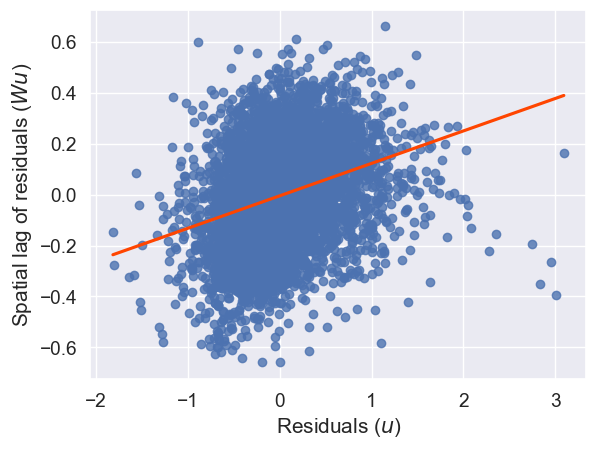

In [40]:
moran = Moran(m6.u, w_knn)
print(moran.I, moran.p_sim) # smaller Moran's I (compared to m2 - .14, but larger than m4 - .4) 
lag_residual = weights.spatial_lag.lag_spatial(w_knn, m6.u)
ax = sns.regplot(
    x=m6.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Residuals ($u$)")
ax.set_ylabel("Spatial lag of residuals ($Wu$)");

# Spatial Error 

> Include spatial lag in the error term of the equation. This violates OLS assumption (normal errors).  

$$
\log{P_i} = \alpha + \sum_k \beta_k X_{ki} + u_i \\
u_i = \lambda u_{lag-i} + \epsilon_i
$$

where $u_{lag-i} = \sum_j w_{i,j} u_j$. 

In [41]:
# Fit spatial error model with `spreg`
# (GMM estimation allowing for heteroskedasticity)
m7 = spreg.GM_Error_Het(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Spatial weights matrix
    w=w_knn,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

In [42]:
print(m7.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
Pseudo R-squared    :      0.6659
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       4.4240379       0.0206722     214.0094550       0.0000000
        accommodates       0.0703114       0.0062888      11.1804555       0.00

0.1864416105991456 0.001


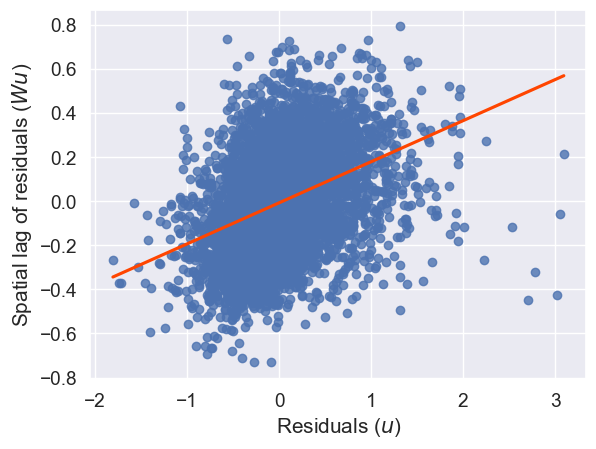

In [43]:
moran = Moran(m7.u, w_knn)
print(moran.I, moran.p_sim) # smaller Moran's I (compared to m2 - .14, but larger than m4 - .4) 
lag_residual = weights.spatial_lag.lag_spatial(w_knn, m7.u)
ax = sns.regplot(
    x=m7.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Residuals ($u$)")
ax.set_ylabel("Spatial lag of residuals ($Wu$)");

# Spatial Lag 

> Spatial lag of the **dependent varialbe**

$$
\log{P_i} = \alpha + \rho \log{P_{lag-i}} + \sum_k \beta_k X_{ki} + \epsilon_i
$$

In [44]:
# Fit spatial lag model with `spreg`
# (GMM estimation)
m8 = spreg.GM_Lag(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Spatial weights matrix
    w=w_knn,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

In [45]:
# Build full table of regression coefficients
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m8.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m8.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m8.z_stat],
    },
    index=m8.name_z
    # Round to four decimals
).round(4)

,Coeff.,Std. Error,P-Value
CONSTANT,2.8453,0.0716,0.0000
accommodates,0.0699,0.0048,0.0000
bathrooms,0.1641,0.0104,0.0000
bedrooms,0.1602,0.0105,0.0000
beds,-0.0369,0.0065,0.0000
rt_Private_room,-0.5012,0.0151,0.0000
rt_Shared_room,-1.1187,0.0366,0.0000
pg_Condominium,0.1119,0.0209,0.0000
pg_House,-0.0014,0.0137,0.9175
pg_Other,0.1192,0.0215,0.0000


0.02906512266191519 0.001


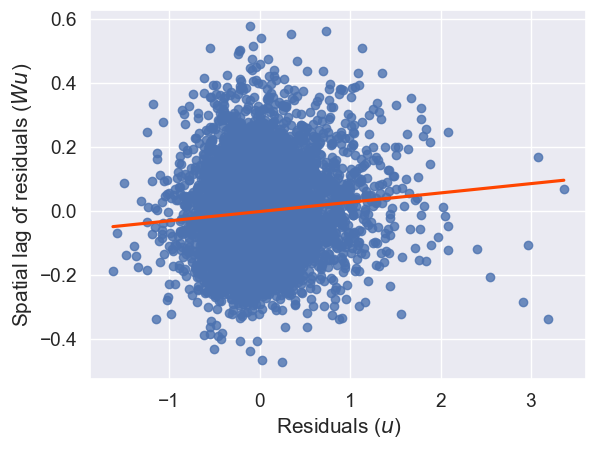

In [46]:
moran = Moran(m8.u, w_knn)
print(moran.I, moran.p_sim) # smaller Moran's I (compared to m2 - .14, but larger than m4 - .4) 
lag_residual = weights.spatial_lag.lag_spatial(w_knn, m8.u)
ax = sns.regplot(
    x=m8.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Residuals ($u$)")
ax.set_ylabel("Spatial lag of residuals ($Wu$)");

In [47]:
# compare models 
pd.DataFrame(
    {
        'models': ['spatial fixed effects', 'spatial regimes', 'SLX model', 'Spatial Error', 'Spatial Lag'],
        'rsq': [m4.r2, m5.r2, m6.r2, 0.66, 0.7052], 
    })

,models,rsq
0,spatial fixed effects,0.711801
1,spatial regimes,0.685342
2,SLX model,0.678604
3,Spatial Error,0.660000
4,Spatial Lag,0.705200


# Sources 

[Geographic Data Science Book - Chapter 11](https://geographicdata.science/book/notebooks/11_regression.html#)

Anselin, Luc and Sergio Rey. 2014. Modern Spatial Econometrics in Practice: A Guide to GeoDa, GeoDaSpace, and Pysal. GeoDa Press.



# Questions? 